In [3]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader
from unet import UNET
import torch.nn.functional as F
import torch.cuda.amp as amp
#from tensorboardX import SummaryWriter
from tqdm import tqdm
import os
import torch
import json

from cityscapes import Cityscapes, printImageLabel

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

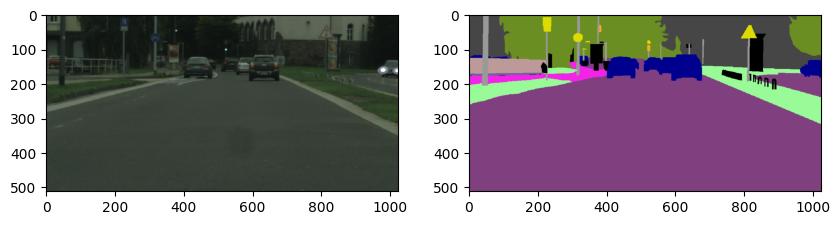

In [4]:
crop_width = 1024
crop_height = 512
composed = T.Compose([T.ToTensor(), T.RandomHorizontalFlip(p=0.5), T.RandomAffine(0, scale=[0.75, 2.0]), T.RandomCrop((crop_height, crop_width), pad_if_needed=True)])
train_data = Cityscapes("./data/Cityscapes", "images/", "labels/", train=True, info_file="info.json", transforms=composed)
val_data = Cityscapes("./data/Cityscapes", "images/", "labels/", train=False, info_file="info.json", transforms=composed)
image, label = train_data[0]
printImageLabel(image, label)

In [5]:
batch_size = 1
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_data, batch_size=1, shuffle=True, num_workers=4, pin_memory=True)

In [ ]:
def val(model, dataloader, validation_run):
    pass
    return 0., 0. #precision, miou  
""" 
    print(f"{'#'*10} VALIDATION {'#' * 10}")

    #prepare info_file to save examples
    info = json.load(open("data/Cityscapes/info.json"))
    palette = {i if i!=19 else 255:info["palette"][i] for i in range(20)}
    mean = torch.as_tensor(info["mean"]).to(device)
    return 0., 0. #precision, miou
    
    with torch.no_grad():
        model.eval() #set the model in the evaluation mode
        precision_record = []
        hist = np.zeros((19, 19)) 

        for i, (image, label) in enumerate(tqdm(dataloader)): 
            label = label.type(torch.LongTensor)
            label = label.long().to(device)
            image = image.to(device)

            #get RGB predict image
            predict = model(image).squeeze() 
            predict = reverse_one_hot(predict) 
            predict = np.array(predict.cpu()) 

            #get RGB label image
            label = label.squeeze()
            label = np.array(label.cpu())

            #compute per pixel accuracy
            precision = compute_global_accuracy(predict, label) 
            hist += fast_hist(label.flatten(), predict.flatten(), args.num_classes) 
            

            path_to_save= args.save_model_path+f"/val_results/{validation_run}" #TODO os.join

            #Save the image
            if args.save_images and i % args.save_images_step == 0 : 
                index_image = get_index(int(i/args.save_images_step))
                os.makedirs(path_to_save, exist_ok=True)
                save_images(mean, palette, image, predict, label, 
                path_to_save+"/"+index_image+".png") #TODO crea il path con os.join
            
            precision_record.append(precision)
           
    
    precision = np.mean(precision_record)
    miou_list = per_class_iu(hist) 
    overall_miou, stuffs_miou, things_miou = stuff_thing_miou(miou_list, stuffs, things)

    print('precision per pixel for test: %.3f' % precision)
    print('mIoU for validation: %.3f' % overall_miou)
    print(f'mIoU per class: {miou_list}') 
    return 0., 0. #precision, miou 
    """

In [7]:
def train(model, optimizer, trainloader, valloader, epoch_start_i=0, num_epochs=50, batch_size=64, validation_step=1, save_model_path="."):             

    
    #Create the scaler
    scaler = amp.GradScaler() 
    
    #Writer
    #writer = SummaryWriter(f"{args.tensorboard_logdir}{suffix}")
    
    #Set the loss of G
    loss_func = torch.nn.CrossEntropyLoss(ignore_index=255)
    
    max_miou = 0
    step = 0

    for epoch in range(epoch_start_i, num_epochs):

        #Set the model to train mode
        model.train()

        #TQDM Setting
        tq = tqdm(total = len(trainloader)*batch_size) 
        tq.set_description('epoch %d, lr %f' % (epoch, lr))
        
        #Loss array
        loss_seg_record = [] 

        for (images, labels) in train_loader:
            #Train with source
            labels = labels.long()
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()

            with amp.autocast():
                output = model(images) 

            loss_seg = loss_func(F.softmax(output, dim=1), labels)
            print(loss_seg.item())                                                                 

            scaler.scale(loss_seg).backward() 

            scaler.step(optimizer)

            scaler.update()
            

            #Print statistics
            tq.update(batch_size)
            tq.set_postfix({"loss_seg" : f'{loss_seg:.6f}'})
            step += 1
            #writer.add_scalar('loss_seg_step', loss_seg, step)
            loss_seg_record.append(loss_seg.item())

    
        tq.close()

        #Loss_seg
        loss_train_seg_mean = np.mean(loss_seg_record)
        #writer.add_scalar('epoch/loss_epoch_train_seg', float(loss_train_seg_mean), epoch)
        print(f'Average loss_seg for epoch {epoch}: {loss_train_seg_mean}')

        #Checkpoint step
        #if epoch % args.checkpoint_step == 0 and epoch != 0:
        #    if not os.path.isdir(args.save_model_path):
        #        os.mkdir(args.save_model_path)
        #    torch.save(model.module.state_dict(), os.path.join(args.save_model_path, 'latest_model.pth'))
        #    torch.save(discriminator.module.state_dict(), os.path.join(args.save_model_path, 'latest_discriminator.pth'))
        
        #Validation step
        if epoch % validation_step == 0 and epoch != 0:
                precision, miou = val(model, valloader, epoch)
                #Check if the current model is the best one
                if miou > max_miou:
                    max_miou = miou
                    os.makedirs(save_model_path, exist_ok=True)
                    torch.save(model.module.state_dict(),
                            os.path.join(save_model_path, 'best_model.pth'))

                #writer.add_scalar('epoch/precision_val', precision, epoch)
                #writer.add_scalar('epoch/overall miou val', miou, epoch)


In [ ]:
lr = 1e-3
momentum = 0.9
weight_decay = 0.0005

model = UNET(3, 19).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

train(model, optimizer, train_loader, val_loader)

val(model, val_loader, validation_run='final')